# Klimaindikatoren für Europa

Dieses Datenset enthält Klimadaten, die aus Reanalyse- und Modellsimulationen stammen und im Copernicus Climate Data Store (CDS) verfügbar sind. Es bietet Klimaindizes, die die Auswirkungen von Klimavariabilität und -wandel auf Sektoren wie Gesundheit, Landwirtschaft, Energie und Wasserwirtschaft beschreiben. Diese Indizes sind wichtig für die Anpassungsplanung auf europäischer und nationaler Ebene und wurden von der Europäischen Umweltagentur (EEA) entwickelt, um die Bedürfnisse nationaler Klimaanpassungsinitiativen in der EU zu erfüllen.

Die Indizes basieren auf Daten aus verschiedenen CDS-Datensätzen und umfassen Temperatur-, Niederschlags- und Windindikatoren. Sie wurden aus den Datensätzen „Climate and energy indicators for Europe from 2005 to 2100“ und „ERA5 hourly data on single levels from 1940 to present“ berechnet. Weitere Indizes stammen aus thematischen Projekten des CDS.

**Informationen zum Datensatz:**
* Quelle: [Climate Indicators](https://cds.climate.copernicus.eu/datasets/sis-ecde-climate-indicators?tab=download)
* Author: T. Tewes (City of Konstanz)
* Notebook Version: 1.2 (Updated: December 13, 2024)

## 1. Festlegen der Pfade und Arbeitsverzeichnisse

In [4]:
import os

''' ---- Verzeichnisse hier angeben ---- '''
download_folder = r".\data\climate-indicators\download"
working_folder = r".\data\climate-indicators\working"
geotiff_folder = r".\data\climate-indicators\geotiff"
csv_folder = r".\data\climate-indicators\csv"
output_folder = r".\data\climate-indicators\output"
''' ----- Ende der Angaben ---- '''

os.makedirs(download_folder, exist_ok=True)
os.makedirs(working_folder, exist_ok=True)
os.makedirs(geotiff_folder, exist_ok=True)
os.makedirs(csv_folder, exist_ok=True)
os.makedirs(output_folder, exist_ok=True)

## 2. Herunterladen und Entpacken des Datensatzes

### 2.1 Authentifizierung

In [5]:
import cdsapi

def main():
    # API-Key für die Authentifizierung
    api_key = "fdae60fd-35d4-436f-825c-c63fedab94a4"
    api_url = "https://cds.climate.copernicus.eu/api"

    # Erstellung des CDS-API-Clients
    client = cdsapi.Client(url=api_url, key=api_key)
    return client

### 2.2 Definieren Sie die „request“ und laden Sie den Datensatz herunter

Definieren Sie zusätzliche Anfragefelder, um sicherzustellen, dass die Anfrage innerhalb der Dateigrößenbeschränkung bleibt. Bei der Arbeit mit Geodaten oder APIs, die Karten- oder Satellitenbilder zurückgeben, kann die Begrenzung des geografischen Interessengebiets verhindern, dass Anfragen zu groß werden und die Datei- oder Verarbeitungsgrenzen überschreiten. Begrenzungsrahmen (Bounding Boxes) werden verwendet, um das geografische Gebiet für solche Anfragen festzulegen.

Die untenstehenden Koordinaten wurden mit dem Tool <a href="https://str-ucture.github.io/bbox-extractor/" target="_blank">BBox Extractor</a> ermittelt.

*BBox Extractor ist ein webbasiertes Tool, das Benutzern hilft, interaktiv Begrenzungsrahmen-Koordinaten im WGS84-Format (Breite/Länge) auszuwählen und zu generieren. Dies ist besonders nützlich für APIs oder Datensätze, die eine Eingabe eines geografischen Gebiets erfordern*

In [6]:
# Definieren der Begrenzungsrahmen-Koordinaten (WGS84-Format)
# Das Koordinatenformat lautet: [Norden, Westen, Süden, Osten]
bbox_wgs84_deutschland = [56.0, 5.8, 47.2, 15.0]
bbox_wgs84_de_standard = [5.7, 47.1, 15.2, 55.2]
bbox_wgs84_konstanz = [47.9, 8.9, 47.6, 9.3]
bbox_wgs84_konstanz_standard = [9.0, 47.6, 9.3, 47.8]  # [West, South, East, North]

# Alternativ können Sie ein Shapefile für eine präzise geografische Filterung verwenden
import geopandas as gpd
import math

# Beispiel: Shapefile von Konstanz laden (WGS84-Projektion)
de_shapefile = r"./shapefiles/de_boundary.shp"
de_gdf = gpd.read_file(de_shapefile)

# Extrahieren Sie den Begrenzungsrahmen des Shapefiles
de_bounds = de_gdf.total_bounds

# Passen Sie den Begrenzungsrahmen an und puffern Sie ihn, um einen etwas größeren
de_bounds_adjusted = [(math.floor(de_bounds[0]* 10)/10)-0.1,
                      (math.floor(de_bounds[1]* 10)/10)-0.1,
                      (math.ceil(de_bounds[2]* 10)/10)+0.1,
                      (math.ceil(de_bounds[3]* 10)/10)+0.1]

# Ordnen Sie die Koordinaten in das Format: [Nord, West, Süd, Ost] um.
bbox_de_bounds_adjusted = [de_bounds_adjusted[3], de_bounds_adjusted[0],
                           de_bounds_adjusted[1], de_bounds_adjusted[2]]

In [7]:
# Fall I: Anforderung ist definiert für Herkunft: Projektionen
# Es werden Variablen aus der Variablengruppe „Heat and cold“ und „Wet and dry“ ausgewählt.

dataset = "sis-ecde-climate-indicators"
request_rea= {
    "variable": [
        "growing_degree_days",
        "heating_degree_days",
        "cooling_degree_days",
        "tropical_nights",
        "hot_days",
        "warmest_three_day_period",
        "heatwave_days",
        "high_utci_days",
        "frost_days",
        "total_precipitation",
        "maximum_consecutive_five_day_precipitation",
        "extreme_precipitation_total",
        "frequency_of_extreme_precipitation",
        "consecutive_dry_days",
        "duration_of_meteorological_droughts",
        "magnitude_of_meteorological_droughts",
        "days_with_high_fire_danger",
        "extreme_wind_speed_days",
        "fire_weather_index"
    ],
    "origin": "reanalysis",
    "temporal_aggregation": ["yearly"],
    "spatial_aggregation": "gridded",
    "other_parameters": [
        "30_c",
        "35_c",
        "40_c"
    ],
    "area": bbox_de_bounds_adjusted
}

In [8]:
# Fall II: Anfrage ist definiert für Herkunft: Projektionen
# Es werden Variablen aus der Variablengruppe „Heat and cold“ und „Wet and dry“ ausgewählt.

dataset = "sis-ecde-climate-indicators"
request_proj = {
    "variable": [
        "growing_degree_days",
        "heating_degree_days",
        "cooling_degree_days",
        "tropical_nights",
        "hot_days",
        "warmest_three_day_period",
        "heatwave_days",
        "frost_days",
        "total_precipitation",
        "maximum_consecutive_five_day_precipitation",
        "extreme_precipitation_total",
        "frequency_of_extreme_precipitation",
        "consecutive_dry_days",
        "duration_of_meteorological_droughts",
        "magnitude_of_meteorological_droughts",
        "days_with_high_fire_danger",
        "extreme_wind_speed_days",
        "fire_weather_index"
    ],
    "origin": "projections",
    "gcm": ["mpi_esm_lr"],
    "rcm": ["cclm4_8_17"],
    "experiment": [
        "rcp4_5",
        "rcp8_5"
    ],
    "ensemble_member": ["r1i1p1"],
    "temporal_aggregation": ["yearly"],
    "spatial_aggregation": "gridded",
    "other_parameters": [
        "30_c",
        "35_c",
        "40_c"
    ],
    "area": bbox_de_bounds_adjusted
}

In [9]:
# Führen Sie es aus, um den Datensatz herunterzuladen:
def main_retrieve():
    for request in [request_rea, request_proj]:
        dataset_filename = f"{dataset}_{request['origin']}_{request['temporal_aggregation'][0]}.zip"
        dataset_filepath = os.path.join(download_folder, dataset_filename)

        # Den Datensatz nur herunterladen, wenn er noch nicht heruntergeladen wurde
        if not os.path.isfile(dataset_filepath):
            # Rufen Sie den CDS-Client nur auf, wenn der Datensatz noch nicht heruntergeladen wurde.
            client = main()
            # Den Datensatz mit den definierten Anforderungsparametern herunterladen
            client.retrieve(dataset, request, dataset_filepath)
        else:
            print("Datensatz bereits heruntergeladen.")
        
if __name__ == "__main__":
    main_retrieve()

Datensatz bereits heruntergeladen.
Datensatz bereits heruntergeladen.


### 2.3 Extrahieren Sie die ZIP-Dateien in Ordner

In [10]:
import zipfile

for request in [request_rea, request_proj]:
    # Definieren Sie den Ordner, in dem die extrahierten Dateien gespeichert werden
    dataset_filename = f"{dataset}_{request['origin']}_{request['temporal_aggregation'][0]}.zip"
    dataset_filepath = os.path.join(download_folder, dataset_filename)

    extract_folder = os.path.join(working_folder, f"{request['origin']}_{request['temporal_aggregation'][0]}")
    os.makedirs(extract_folder, exist_ok=True)

    # Entpacken der ZIP-Datei
    try:
        if not os.listdir(extract_folder):
            # Versuchen Sie, die ZIP-Datei zu öffnen und zu extrahieren
            with zipfile.ZipFile(dataset_filepath, 'r') as zip_ref:
                zip_ref.extractall(extract_folder)
                print(f"Dateien erfolgreich extrahiert nach: {extract_folder}")
        else:
            print("Ordner ist nicht leer. Entpacken überspringen.")
    except FileNotFoundError:
        print(f"Fehler: Die Datei {dataset_filepath} wurde nicht gefunden.")
    except zipfile.BadZipFile:
        print(f"Fehler: Die Datei {dataset_filepath} ist keine gültige ZIP-Datei.")
    except Exception as e:
        print(f"Ein unerwarteter Fehler ist aufgetreten: {e}")

Ordner ist nicht leer. Entpacken überspringen.
Ordner ist nicht leer. Entpacken überspringen.


## 3. Untersuchen der Metadaten der NetCDF4-Datei

In [11]:
# Definieren den Ursprung der Daten, entweder „projections“ oder „reanalysis“
origin = "reanalysis"

# Erstellen den Pfad zum Ordner, in dem die extrahierten Daten gespeichert werden
extract_folder = os.path.join(working_folder, f"{origin}_{request['temporal_aggregation'][0]}")

### 3.1 Erstellen eines DataFrame mit verfügbaren NetCDF-Dateien

In [12]:
import re
import pandas as pd
import netCDF4 as nc

def meta(filename):
    # Überprüfen, ob der Dateiname dem erwarteten Muster entspricht
    match = re.search(r"(?P<index>\w+?)_(?P<ds_variable>[a-zA-Z_]+?)-(?P<ds_origin>\w+?)-(?P<ds_temporal_aggregation>\w+)(?:-(?P<ds_stat>min|max|mean))?(?:-(?P<ds_grid>\d+deg))?(?:-(?P<ds_rcp>rcp_\d+_\d+))?",filename)

    # Fehler ausgeben, wenn der Dateiname nicht dem erwarteten Schema entspricht
    if not match:
        match = re.search("Der angegebene Dateiname entspricht nicht dem erwarteten Benennungsschema.")

    # Funktion zum Extrahieren des Variablennamens aus der NetCDF-Datei
    def get_nc_variable():
        with nc.Dataset(os.path.join(extract_folder, filename), 'r') as nc_dataset:
            nc_variable_name = nc_dataset.variables.keys()
            return [*nc_variable_name][0]

    # Metadaten als Dictionary zurückgeben
    return dict(
        filename=filename,
        path=os.path.join(extract_folder, filename),
        # index=match.group('index'),
        ds_variable=match.group('ds_variable'),
        ds_origin=match.group('ds_origin'),
        ds_temporal_aggregation=match.group('ds_temporal_aggregation'),
        # ds_stat=match.group('ds_stat'),
        variable_name=get_nc_variable(),
        ds_grid=match.group('ds_grid'),
        ds_rcp=match.group('ds_rcp')
    )

# Metadaten für alle NetCDF-Dateien im Ordner extrahieren
# Das Dictionary 'nc_files' enthält alle relevanten Metadaten der verfügbaren NetCDF4-Dateien
# Dieses Dictionary wird später verwendet, um die Dateien in GeoTiff zu konvertieren
nc_files = [meta(f) for f in os.listdir(extract_folder) if f.endswith('.nc')]
df_nc_files = pd.DataFrame.from_dict(nc_files)

# Pandas-Anzeigeoptionen anpassen
pd.options.display.max_colwidth = 24

# DataFrame anzeigen, ohne die Spalte 'path' darzustellen
df_nc_files.head(10).loc[:, df_nc_files.columns != 'path']

filename              ds_variable   ds_origin  \
0  02_growing_degree_da...      growing_degree_days  reanalysis   
1  03_heating_degree_da...      heating_degree_days  reanalysis   
2  04_cooling_degree_da...      cooling_degree_days  reanalysis   
3  05_tropical_nights-r...          tropical_nights  reanalysis   
4  06_hot_days-reanalys...                 hot_days  reanalysis   
5  06_hot_days-reanalys...                 hot_days  reanalysis   
6  06_hot_days-reanalys...                 hot_days  reanalysis   
7  07_warmest_three_day...  warmest_three_day_pe...  reanalysis   
8  09_heat_waves_climat...  heat_waves_climatolo...  reanalysis   
9  10_high_utci_days-re...           high_utci_days  reanalysis   

  ds_temporal_aggregation   variable_name ds_grid ds_rcp  
0                  yearly             t2m    None   None  
1                  yearly            data    None   None  
2                  yearly            data    None   None  
3                  yearly             t2m    None   None  
4                  yearly             t2m   30deg   None  
5                  yearly             t2m   35deg   None  
6                  yearly             t2m   40deg   None  
7                  yearly             t2m    None   None  
8                  yearly            data    None   None  
9                  yearly  high_utci_days    None   None

### 3.2 Einzigartige Variablennamen und verfügbare Variablen ausgeben

In [13]:
# Variable definieren, um bereits verarbeitete Variablennamen zu speichern und Duplikate zu vermeiden  
seen_variables = set()

# Alle Variablen in jeder NetCDF-Datei auflisten  
for i, nc_file in enumerate(nc_files):
    variable_name = nc_file['variable_name']
    
    # Überspringen, wenn die Variable bereits verarbeitet wurde  
    if variable_name in seen_variables:
        continue

    # NetCDF-Datei im Lesemodus öffnen  
    with nc.Dataset(nc_file['path'], mode='r') as nc_dataset:  
        # Alle Variablen im aktuellen Datensatz auflisten  
        variables_list = list(nc_dataset.variables.keys())  
        
        # Details der Datei und ihrer Variablen ausgeben  
        print(f"{i + 1:<2} {variable_name:<18}: Verfügbare Variablen: {variables_list}") 
    
    # Diese Variable als verarbeitet markieren  
    seen_variables.add(variable_name)

1  t2m               : Verfügbare Variablen: ['t2m', 'time', 'realization', 'lat', 'lon']
2  data              : Verfügbare Variablen: ['data', 'time', 'realization', 'lat', 'lon']
10 high_utci_days    : Verfügbare Variablen: ['high_utci_days', 'time', 'height', 'lon', 'lat']
12 tp                : Verfügbare Variablen: ['tp', 'time', 'realization', 'lat', 'lon']
16 cdd               : Verfügbare Variablen: ['cdd', 'realization', 'lat', 'lon', 'time']
17 dmd               : Verfügbare Variablen: ['dmd', 'lat', 'lon', 'realization', 'time']
19 fwi               : Verfügbare Variablen: ['fwi', 'time', 'lon', 'lat']


In [14]:
# Alle Variableninformationen in jeder NetCDF-Datei auflisten  
seen_variables = set()

# Alle variablen Informationen in jeder NetCDF-Datei auflisten
for i, nc_file in enumerate(nc_files):
    variable_name = nc_file['variable_name']
    
    # Überspringen, wenn die Variable bereits verarbeitet wurde
    if variable_name in seen_variables:
        continue
    
    # NetCDF-Datei im Lesemodus öffnen
    with nc.Dataset(nc_file['path'], mode='r') as nc_dataset:  
        # Primärvariable-Daten abrufen  
        variable_data = nc_dataset[variable_name]  

        # Zusammenfassung der Primärvariable erstellen  
        summary = {  
            "Variablenname": variable_name,  
            "Datentyp": variable_data.dtype,  
            "Form": variable_data.shape,  
            "Variableninfo": f"{variable_data.dimensions}",  
            "Einheiten": getattr(variable_data, "units", "N/A"),  
            "Langer Name": getattr(variable_data, "long_name", "N/A"),  
        }  

        # Datensatz-Zusammenfassung als DataFrame zur besseren Visualisierung anzeigen  
        nc_summary = pd.DataFrame(list(summary.items()), columns=['Beschreibung', 'Bemerkungen'])  
        print(f"{i + 1}. Zusammenfassung der Variable '{variable_name}':")  
        display(nc_summary)  

    # Variablenname zur Liste der bereits verarbeiteten Variablen hinzufügen  
    seen_variables.add(variable_name)  

    # Ausgabe begrenzen  
    output_limit = 2  
    if len(seen_variables) >= output_limit:  
        print(f".... (Ausgabe auf die ersten {output_limit} Variablen gekürzt)")  
        break  

1. Zusammenfassung der Variable 't2m':


Beschreibung             Bemerkungen
0  Variablenname                     t2m
1       Datentyp                 float32
2           Form            (84, 32, 38)
3  Variableninfo  ('time', 'lat', 'lon')
4      Einheiten                       1
5    Langer Name                     N/A

2. Zusammenfassung der Variable 'data':


Beschreibung             Bemerkungen
0  Variablenname                    data
1       Datentyp                 float32
2           Form            (84, 32, 38)
3  Variableninfo  ('time', 'lat', 'lon')
4      Einheiten                       K
5    Langer Name                     N/A

.... (Ausgabe auf die ersten 2 Variablen gekürzt)


## 4. Exportieren der NetCDF4-Dateien im CSV-Format

### 4.1 Definieren eine Funktion zum Konvertieren von NetCDF-Daten in DataFrame

In [15]:
import xarray as xr

# Funktion zur Konvertierung von NetCDF-Daten in ein Pandas DataFrame
def netcdf_to_dataframe(
    nc_file,
    bounding_box=None):

    # Öffne das NetCDF-Dataset im Lesemodus
    with xr.open_dataset(nc_file['path']) as nc_dataset:
        # Zugriff auf die Variablendaten aus dem Datensatz
        variable_data = nc_dataset[nc_file['variable_name']]
        
        # Sicherstellen, dass die Namen für Breiten- und Längengrad korrekt sind
        latitude_name = 'latitude' if 'latitude' in nc_dataset.coords else 'lat'
        longitude_name = 'longitude' if 'longitude' in nc_dataset.coords else 'lon'
        
        # Falls eine Begrenzungsbox angegeben ist, die Daten filtern
        if bounding_box:
            filtered_data = variable_data.where(
                (nc_dataset[latitude_name] >= bounding_box[1]) & (nc_dataset[latitude_name] <= bounding_box[3]) &
                (nc_dataset[longitude_name] >= bounding_box[0]) & (nc_dataset[longitude_name] <= bounding_box[2]),
                drop=True
            )
        else:
            filtered_data = variable_data

        # Umwandlung des xarray-Datensatzes in ein Pandas DataFrame
        df = filtered_data.to_dataframe().reset_index().set_index(['time', latitude_name, longitude_name])

        # Entfernen nicht benötigter Spalten (variiert je nach Datensatz)
        if 'height' in df.columns:
            df = df.drop(columns=['height'])
        if 'quantile' in df.columns:
            df = df.drop(columns=['quantile'])

        return df

### 4.2 DataFrame erstellen und als CSV-Datei exportieren

In [16]:
# Definieren den Ursprung der Daten, entweder „projections“ oder „reanalysis“
origin = "projections"

In [ ]:
# Ordner basierend auf zeitlicher Aggregation erstellen
subset_csv_folder = os.path.join(csv_folder, f"{origin}_{request['temporal_aggregation'][0]}")
os.makedirs(subset_csv_folder, exist_ok=True)

# Alle netCDF4-Dateien in einzelne CSV-Dateien exportieren
for nc_file in nc_files:
    # CSV-Dateiname und Pfad für die Ausgabe definieren
    csv_filename = f"{nc_file['filename']}.csv"
    csv_filepath = os.path.join(subset_csv_folder, csv_filename)

    # Exportiere das DataFrame als CSV, falls es noch nicht existiert
    if not os.path.isfile(csv_filepath):
        dataframe = netcdf_to_dataframe(nc_file=nc_file)
        dataframe.to_csv(csv_filepath, sep=",", encoding='utf8')
    else:
        print(f"Datei existiert bereits unter {csv_filepath}.\nÜberspringen den Export.")
        break

print("Letzte vorhandene CSV-Datei lesen...")
dataframe = pd.read_csv(csv_filepath).set_index(['time', 'lat', 'lon'])

# Zeige das DataFrame an
dataframe

Datei existiert bereits unter .\data\climate-indicators\csv\projections_yearly\02_growing_degree_days-reanalysis-yearly-grid-1940-2023-v1.0.area-subset.55.2.15.2.47.1.5.7.nc.csv.
Überspringen den Export.
Letzte vorhandene CSV-Datei lesen...


realization        t2m
time       lat   lon                          
1940-01-01 47.25 5.75             0  2209.1602
                 6.00             0  2158.9377
                 6.25             0  2055.9540
                 6.50             0  1832.0024
                 6.75             0  1662.9482
...                             ...        ...
2023-01-01 55.00 14.00            0  2009.1061
                 14.25            0  2005.1495
                 14.50            0  1994.5411
                 14.75            0  1979.5626
                 15.00            0  1966.1664

[102144 rows x 2 columns]

## 5. Analyse und Visualisierung Optionen

### 5.1 Definieren ein ein interaktives Widget, um eine Variable für die Visualisierung auszuwählen

> Wichtig: Wählen Sie die **Variable**, die für die Visualisierung von Interesse ist.

In [29]:
import ipywidgets as ipywidgets

# Liste aller verfügbaren Variablen erstellen
ds_variable_list = df_nc_files['ds_variable'].unique()

# Dropdown-Widget für die Auswahl einer Variablen erstellen
selected_ds_variable = ipywidgets.Dropdown(
    options=ds_variable_list,
    description='Eine Variable auswählen:',
    disabled=False,
    style={'description_width': 'auto'}
)
selected_ds_variable

Dropdown(description='Eine Variable auswählen:', options=('growing_degree_days', 'heating_degree_days', 'cooli…

### 5.2 Definieren farbkodierte Designstile für die Visualisierung

In [19]:
# Farben
color_reanalyse = "#008000" #Reanalyse
color_rcp4_5 = "#005d82" #RCP4.5
color_rcp8_5 = "#ce1657" #RCP8.5

# Darstellung der Reanalyse-Daten
design_reanalyse = {
    'label': 'Reanalyse',
    'color': color_reanalyse,
    'marker': 'o',
    'linestyle': '-',
    'markersize': 4,
    'linewidth': 0.5
}

# Darstellung der RCP4.5-Daten
design_rcp45 = {
    'label': 'RCP4.5',
    'color': color_rcp4_5,
    'marker': 'o',
    'linestyle': ':',
    'markersize': 3,
    'linewidth': 0.5
}

# Darstellung der RCP8.5-Daten
design_rcp85 = {
    'label': 'RCP8.5',
    'color': color_rcp8_5,
    'marker': 'o',
    'linestyle': ':',
    'markersize': 3,
    'linewidth': 0.5
}

# Darstellung der Trendlinie RCP4.5
design_rcp45_trend = {
    'label': 'Trend RCP4.5',
    'color': color_rcp4_5,
    'linestyle': ':',
    'linewidth': 1.5
}

# Darstellung der Trendlinie RCP8.5
design_rcp85_trend = {
    'label': 'Trend RCP8.5',
    'color': color_rcp8_5,
    'linestyle': ':',
    'linewidth': 1.5
}

# Darstellung der Trennline zwischen Reanalyse und Projektionsdaten
datum_trennlinie = '2024-01-01'  # wenn neuere Reanalyse-Daten vorliegen, müsste dieses Datum angepasst werden
design_trennlinie = {
    'color': 'grey',
    'linestyle': '--',
    'linewidth': 2.5
}

### 5.3 Abrufen und Zusammenführen von Daten aus Reanalyse- und Projektionsdatensätzen

In [20]:
# Daten aus der Reanalyse abrufen
origin = "reanalysis"
extract_folder = os.path.join(working_folder, f"{origin}_{request['temporal_aggregation'][0]}")
nc_files_reanalysis = [meta(f) for f in os.listdir(extract_folder) if f"{selected_ds_variable.value}" in f]

# Daten aus den Projektionen abrufen
origin = "projections"
extract_folder = os.path.join(working_folder, f"{origin}_{request['temporal_aggregation'][0]}")
nc_files_projections = [meta(f) for f in os.listdir(extract_folder) if f"{selected_ds_variable.value}" in f]

# Daten zusammenführen und DataFrame erstellen
nc_files_merged = nc_files_reanalysis + nc_files_projections
df_nc_files_merged = pd.DataFrame.from_dict(nc_files_merged)

# 'path'-Spalte ausschließen
df_nc_files_merged.loc[:, df_nc_files_merged.columns != 'path']

filename          ds_variable    ds_origin  \
0  02_growing_degree_da...  growing_degree_days   reanalysis   
1  02_growing_degree_da...  growing_degree_days  projections   
2  02_growing_degree_da...  growing_degree_days  projections   

  ds_temporal_aggregation variable_name ds_grid   ds_rcp  
0                  yearly           t2m    None     None  
1                  yearly     tasAdjust    None  rcp_4_5  
2                  yearly     tasAdjust    None  rcp_8_5

In [21]:
nc_file_reanalysis = None
nc_file_proj_rcp45 = None
nc_file_proj_rcp85 = None

# Bestimmte Zeilen aus den zusammengeführten Daten extrahieren
for file in nc_files_merged:
    # Erstes Vorkommen, bei dem ds_origin 'reanalysis' ist
    if file['ds_origin'] == 'reanalysis' and nc_file_reanalysis is None:
        nc_file_reanalysis = file
    
    # Erstes Vorkommen, bei dem ds_origin 'projections' und ds_rcp 'rcp_4_5' ist
    if file['ds_origin'] == 'projections' and file['ds_rcp'] == 'rcp_4_5' and nc_file_proj_rcp45 is None:
        nc_file_proj_rcp45 = file
    
    # Erstes Vorkommen, bei dem ds_origin 'projections' und ds_rcp 'rcp_8_5' ist
    if file['ds_origin'] == 'projections' and file['ds_rcp'] == 'rcp_8_5' and nc_file_proj_rcp85 is None:
        nc_file_proj_rcp85 = file

### 5.4 Berechnung des Jahresmittels und der Anomalie für Reanalysedaten

In [22]:
def compute_reanalysis_yearly_mean(start_year, end_year):
    # Lade die nc_file_reanalysis und konvertiere sie in ein DataFrame
    variable_name_reanalysis = nc_file_reanalysis['variable_name']
    df_reanalysis = netcdf_to_dataframe(nc_file=nc_file_reanalysis,
                                        bounding_box=bbox_wgs84_konstanz_standard).reset_index()

    # Filtere das DataFrame für den Referenzzeitraum
    df_reanalysis['time'] = pd.to_datetime(df_reanalysis['time'])
    df_reanalysis_ref_period = df_reanalysis[(df_reanalysis['time'].dt.year >= start_year) &
                                             (df_reanalysis['time'].dt.year <= end_year)]

    # Berechne den Mittelwert für den Referenzzeitraum und die Anomalie
    reference_mean = df_reanalysis_ref_period[variable_name_reanalysis].mean()
    df_reanalysis.loc[:, 'anomaly'] = df_reanalysis[variable_name_reanalysis] - reference_mean

    # Berechne den jährlichen Mittelwert und entferne die Spalten 'lat' und 'lon'
    df_reanalysis_yearly_mean = (
        df_reanalysis
        .groupby(df_reanalysis['time'].dt.year)
        .mean()
        .drop(['lat', 'lon'], axis=1)
    )

    return variable_name_reanalysis, df_reanalysis, df_reanalysis_yearly_mean

# Berechne den jährlichen Mittelwert für die Reanalyse-Daten
start_year, end_year = 1971, 2010
variable_name_reanalysis, df_reanalysis, df_reanalysis_yearly_mean = compute_reanalysis_yearly_mean(start_year=start_year, end_year=end_year)

# Zeige das DataFrame an
df_reanalysis_yearly_mean.head()

time  realization          t2m     anomaly
time                                                 
1940 1940-01-01          0.0  1850.592773 -219.633362
1941 1941-01-01          0.0  1655.679443 -414.546570
1942 1942-01-01          0.0  2059.707275  -10.518799
1943 1943-01-01          0.0  2053.417969  -16.807983
1944 1944-01-01          0.0  1942.366699 -127.859436

### 5.5 Visualisierung der jährlichen Anomalien mit einer Balkengrafik

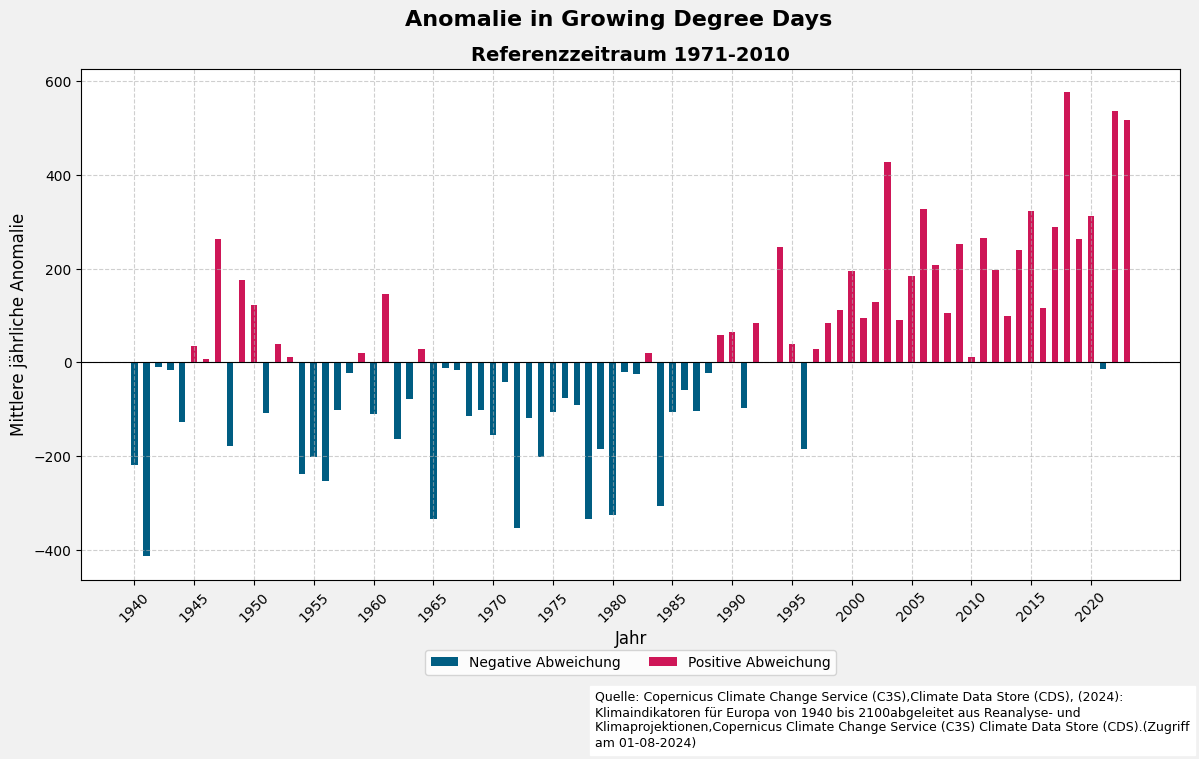

In [23]:
import matplotlib.pyplot as plt

# Erstelle ein Diagramm
fig, ax = plt.subplots(figsize=(12, 7), facecolor='#f1f1f1', edgecolor='k')

# Zeichne negative Werte
ax.bar(df_reanalysis_yearly_mean['time'][df_reanalysis_yearly_mean['anomaly'] < 0], 
       df_reanalysis_yearly_mean['anomaly'][df_reanalysis_yearly_mean['anomaly'] < 0], 
       width=200,
       color=color_rcp4_5,
       label='Negative Abweichung')

# Zeichne positive Werte
ax.bar(df_reanalysis_yearly_mean['time'][df_reanalysis_yearly_mean['anomaly'] >= 0], 
       df_reanalysis_yearly_mean['anomaly'][df_reanalysis_yearly_mean['anomaly'] >= 0], 
       width=200,
       color=color_rcp8_5,
       label='Positive Abweichung')

# Füge eine Nulllinie hinzu
ax.axhline(0, color='black', linewidth=0.8)

# Achsenbeschriftungen und Titel setzen
ax.set_xlabel("Jahr", fontsize=12)
ax.set_ylabel("Mittlere jährliche Anomalie", fontsize=12)
ax.set_title(f"Referenzzeitraum {start_year}-{end_year}", fontsize=14, fontweight='bold')
fig.suptitle(f"Anomalie in {selected_ds_variable.value.replace('_',' ').title()}",
             fontsize=16,
             fontweight='bold',
             x=0.52)

# Raster hinzufügen
ax.grid(visible=True, color='#b0b0b0', linestyle='--', linewidth=0.8, alpha=0.6)

# X-Achse: Alle 5-Jahres-Intervalle anzeigen
years = pd.date_range(start=df_reanalysis_yearly_mean['time'].min(),
                      end=df_reanalysis_yearly_mean['time'].max(),
                      freq='5YE').year
ax.set_xticks(pd.to_datetime(years, format='%Y'))
ax.set_xticklabels(years, rotation=45)

# Beschreibung hinzufügen
plt.figtext(
    0.5,
    -0.035,
    (
       'Quelle: Copernicus Climate Change Service (C3S),'
       'Climate Data Store (CDS), (2024): Klimaindikatoren für Europa von 1940 bis 2100'
       'abgeleitet aus Reanalyse- und Klimaprojektionen,'
       'Copernicus Climate Change Service (C3S) Climate Data Store (CDS).'
       '(Zugriff am 01-08-2024)'
    ),
    ha='left',
    va='center',
    fontsize=9,
    wrap=True,
    backgroundcolor='w',
)

# Legende hinzufügen
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=2)

# Layout anpassen und Diagramm anzeigen
plt.tight_layout()
plt.show()

### 5.6 Visualisierung des Jahresmittelwerts mit einer Trendlinie

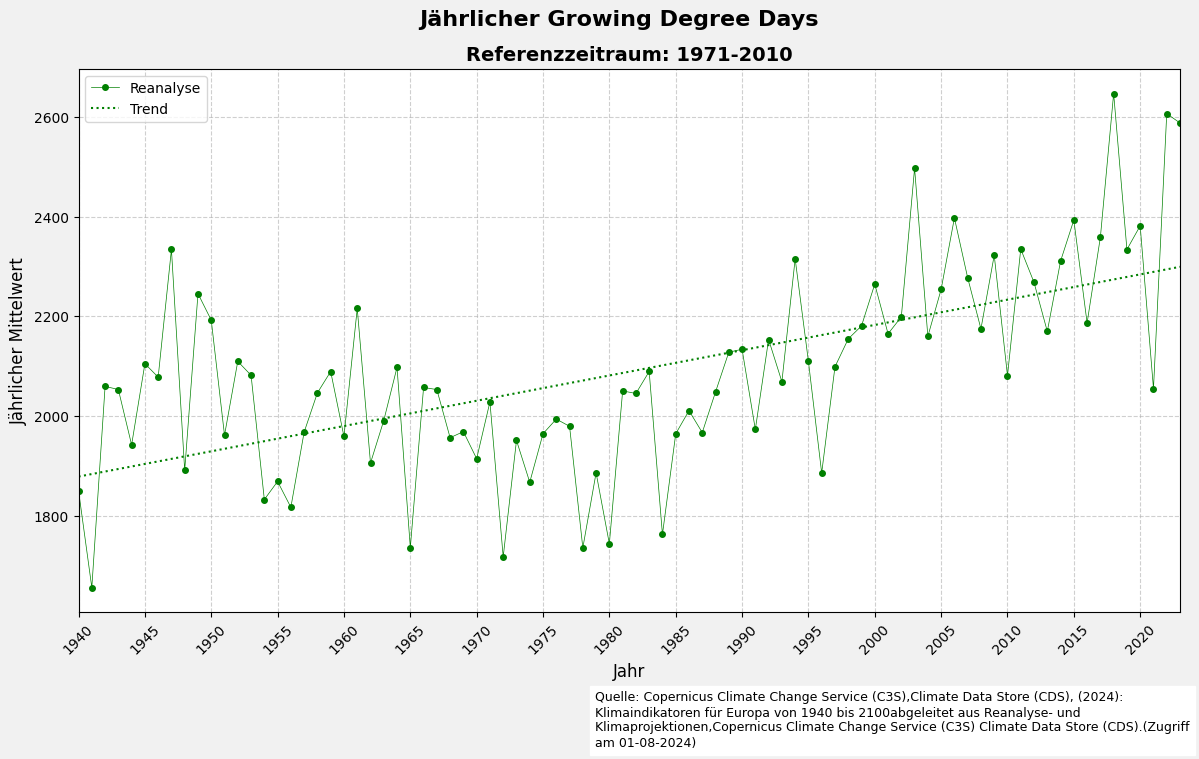

In [24]:
import numpy as np

# Erstelle ein Diagramm
fig, ax = plt.subplots(figsize=(12, 7), facecolor='#f1f1f1', edgecolor='k')

# Zeichne die Zeitreihe
plt.plot(df_reanalysis_yearly_mean['time'],
         df_reanalysis_yearly_mean[variable_name_reanalysis],
         **design_reanalyse)

# Zeichne die Trendlinie
z = np.polyfit(df_reanalysis_yearly_mean['time'].dt.year,
               df_reanalysis_yearly_mean[variable_name_reanalysis], 1)
p = np.poly1d(z)
ax.plot(df_reanalysis_yearly_mean['time'],
        p(df_reanalysis_yearly_mean['time'].dt.year),
        label='Trend',
        color=color_reanalyse,
        linestyle=":",
        linewidth=1.5)

# Achsenbeschriftungen und Titel setzen
ax.set_xlabel("Jahr", fontsize=12)
ax.set_ylabel("Jährlicher Mittelwert", fontsize=12)
ax.set_title(f"Referenzzeitraum: {start_year}-{end_year}",
             fontsize=14,
             fontweight='bold')

# Haupttitel setzen
fig.suptitle(f"Jährlicher {selected_ds_variable.value.replace('_',' ').title()}",
             fontsize=16,
             fontweight='bold',
             x=0.52)

# Begrenzung der X-Achse setzen
plt.xlim(df_reanalysis_yearly_mean['time'].min(), df_reanalysis_yearly_mean['time'].max())

# Raster hinzufügen
ax.grid(visible=True,
        color='#b0b0b0',
        linestyle='--',
        linewidth=0.8,
        alpha=0.6)

# X-Achse: Alle 5-Jahres-Intervalle anzeigen
years = pd.date_range(start=df_reanalysis_yearly_mean['time'].min(),
                      end=df_reanalysis_yearly_mean['time'].max(),
                      freq='5YE').year
ax.set_xticks(pd.to_datetime(years, format='%Y'))
ax.set_xticklabels(years, rotation=45)

# Beschreibung hinzufügen
plt.figtext(
    0.5,
    -0.035,
    (
       'Quelle: Copernicus Climate Change Service (C3S),'
       'Climate Data Store (CDS), (2024): Klimaindikatoren für Europa von 1940 bis 2100'
       'abgeleitet aus Reanalyse- und Klimaprojektionen,'
       'Copernicus Climate Change Service (C3S) Climate Data Store (CDS).'
       '(Zugriff am 01-08-2024)'
    ),
    ha='left',
    va='center',
    fontsize=9,
    wrap=True,
    backgroundcolor='w',
)

# Legende hinzufügen
ax.legend()

# Layout anpassen und Diagramm anzeigen
plt.tight_layout()
plt.show()

### 5.7 Aufbereitung von Reanalyse- und Projektionsdaten für die Visualisierung

In [25]:
def compute_projection_data(start_year, intermediate_year, end_year):
    # Extrahieren der Variablendaten aus den NetCDF-Dateien
    variable_name_reanalysis = nc_file_reanalysis['variable_name']
    df_reanalysis = netcdf_to_dataframe(nc_file=nc_file_reanalysis,
                                        bounding_box=bbox_wgs84_konstanz_standard).reset_index()
    
    variable_name_projections = nc_file_proj_rcp45['variable_name']
    df_rcp45 = netcdf_to_dataframe(nc_file=nc_file_proj_rcp45,
                                   bounding_box=bbox_wgs84_konstanz_standard).reset_index()
    df_rcp85 = netcdf_to_dataframe(nc_file=nc_file_proj_rcp85,
                                   bounding_box=bbox_wgs84_konstanz_standard).reset_index()

    # Konvertierung der Zeitspalte in das Datetime-Format
    df_reanalysis['time'] = pd.to_datetime(df_reanalysis['time'])
    df_rcp45['time'] = pd.to_datetime(df_rcp45['time'])
    df_rcp85['time'] = pd.to_datetime(df_rcp85['time'])

    # Filtern der Datensätze auf der Grundlage der angegebenen Zeiträume
    df_reanalysis = df_reanalysis[(df_reanalysis['time'].dt.year >= start_year) & 
                                  (df_reanalysis['time'].dt.year <= intermediate_year)]
    df_rcp45 = df_rcp45[(df_rcp45['time'].dt.year >= intermediate_year + 1) & 
                        (df_rcp45['time'].dt.year <= end_year)]
    df_rcp85 = df_rcp85[(df_rcp85['time'].dt.year >= intermediate_year + 1) &
                        (df_rcp85['time'].dt.year <= end_year)]

    # Hinzufügen der Spalte „Jahr“ zu den Projektionsdaten zur einfacheren Aggregation
    df_rcp45['Year'] = df_rcp45['time'].dt.year
    df_rcp85['Year'] = df_rcp85['time'].dt.year

    # Berechnung des gleitenden 30-Jahres-Durchschnitts für beide Szenarien
    df_rcp45 = compute_fixed_30_year_average(df_rcp45, variable_name_projections)
    df_rcp85 = compute_fixed_30_year_average(df_rcp85, variable_name_projections)

    return variable_name_reanalysis, df_reanalysis, variable_name_projections, df_rcp45, df_rcp85

def compute_fixed_30_year_average(df, column):
    # Stellen sicher, dass die Daten nach „Jahr“ sortiert sind, bevor Sie die rollierende Statistik berechnen
    df = df.sort_values(by='Year')
    
    # Berechnung des gleitenden 30-Jahres-Durchschnitts und der Standardabweichung (zentriertes Fenster)
    df['30_year_avg'] = df[column].rolling(window=30, min_periods=1, center=True).mean()
    df['30_year_std'] = df[column].rolling(window=30, min_periods=1, center=True).std()
    
    return df

# Definieren den Jahresbereich
start_year = 1940
intermediate_year = 2023
end_year = 2100

variable_name_reanalysis, df_reanalysis, variable_name_projections, df_rcp45, df_rcp85 = compute_projection_data(start_year,intermediate_year, end_year)

### 5.8 Visualisierung der Jahresmittelwerte der Reanalyse- und Klimaprojektionsdaten (RCP4.5 und RCP8.5) mit einer Trendlinie

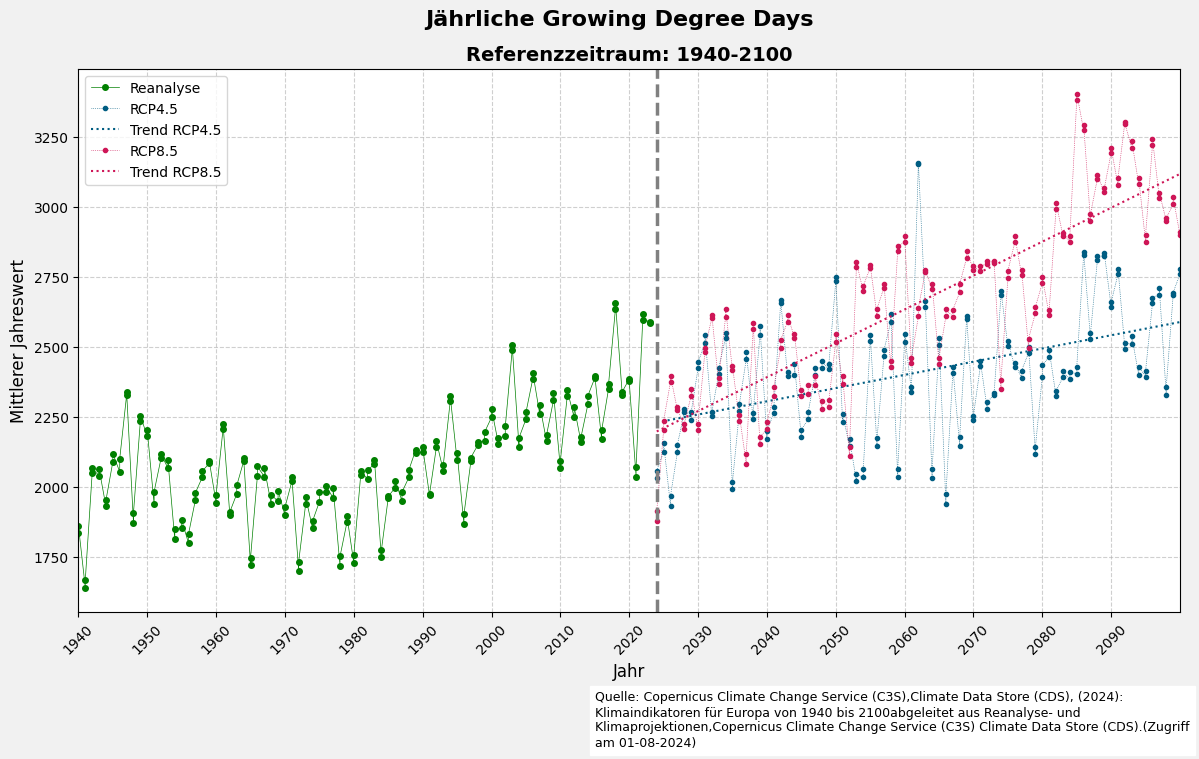

In [26]:
# Erstelle ein Diagramm
fig, ax = plt.subplots(figsize=(12, 7), facecolor='#f1f1f1', edgecolor='k')

# Reanalyse-Daten plotten
plt.plot(df_reanalysis['time'],
         df_reanalysis[variable_name_reanalysis],
         **design_reanalyse)

# RCP4.5-Szenario-Daten und Trendlinie plotten
plt.plot(df_rcp45['time'],
         df_rcp45[variable_name_projections],
         **design_rcp45)

# Lineare Trendlinie für das RCP4.5-Szenario berechnen
z = np.polyfit(df_rcp45['time'].dt.year, df_rcp45[variable_name_projections], 1)
p = np.poly1d(z)

# Trendlinie für RCP4.5 plotten
plt.plot(df_rcp45['time'],
         p(df_rcp45['time'].dt.year),
         **design_rcp45_trend)

# RCP8.5-Szenario-Daten und Trendlinie plotten
plt.plot(df_rcp85['time'],
         df_rcp85[variable_name_projections],
         **design_rcp85)

# Lineare Trendlinie für das RCP8.5-Szenario berechnen
z = np.polyfit(df_rcp85['time'].dt.year, df_rcp85[variable_name_projections], 1)
p = np.poly1d(z)

# Trendlinie für RCP8.5 plotten
plt.plot(df_rcp85['time'],
         p(df_rcp85['time'].dt.year),
         **design_rcp85_trend)

# Vertikale Trennlinie hinzufügen, um zwischen historischen Daten und Projektionen zu unterscheiden
plt.axvline(x=pd.Timestamp('2024-01-01'), **design_trennlinie)

# Achsentitel setzen
ax.set_xlabel("Jahr", fontsize=12)
ax.set_ylabel("Mittlerer Jahreswert", fontsize=12)
ax.set_title(f"Referenzzeitraum: {start_year}-{end_year}",
             fontsize=14,
             fontweight='bold')

# Haupttitel setzen
fig.suptitle(f"Jährliche {selected_ds_variable.value.replace('_', ' ').title()}",
             fontsize=16,
             fontweight='bold',
             x=0.52)

# Begrenzung der x-Achse auf den relevanten Datenbereich
plt.xlim(df_reanalysis['time'].min(), df_rcp45['time'].max())

# Raster für bessere Lesbarkeit hinzufügen
ax.grid(visible=True,
        color='#b0b0b0',
        linestyle='--',
        linewidth=0.8,
        alpha=0.6)

# X-Achse: Alle 10-Jahres-Intervalle anzeigen
years = pd.date_range(start=df_reanalysis['time'].min(),
                      end=df_rcp45['time'].max(),
                      freq='10YE').year
ax.set_xticks(pd.to_datetime(years, format='%Y'))
ax.set_xticklabels(years, rotation=45)

# Beschreibung hinzufügen
plt.figtext(
    0.5,
    -0.035,
    (
       'Quelle: Copernicus Climate Change Service (C3S),'
       'Climate Data Store (CDS), (2024): Klimaindikatoren für Europa von 1940 bis 2100'
       'abgeleitet aus Reanalyse- und Klimaprojektionen,'
       'Copernicus Climate Change Service (C3S) Climate Data Store (CDS).'
       '(Zugriff am 01-08-2024)'
    ),
    ha='left',
    va='center',
    fontsize=9,
    wrap=True,
    backgroundcolor='w',
)

# Legende hinzufügen
ax.legend()

# Layout anpassen und Diagramm anzeigen
plt.tight_layout()
plt.show()


### 5.9 Visualisierung der Jahresmittelwerte der Reanalyse- und Klimaprojektionsdaten (RCP4.5 und RCP8.5) mit Standardabweichung

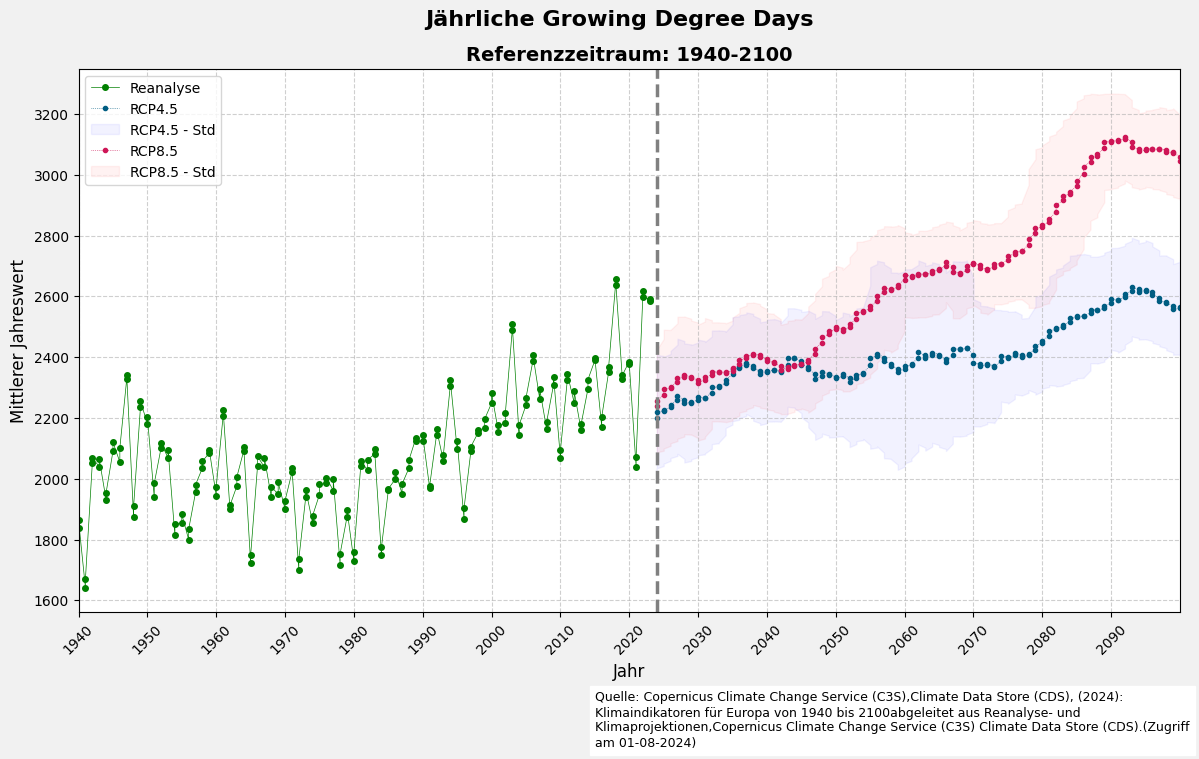

In [27]:
# Erstelle ein Diagramm
fig, ax = plt.subplots(figsize=(12, 7), facecolor='#f1f1f1', edgecolor='k')

# Reanalyse-Daten plotten
plt.plot(df_reanalysis['time'],
         df_reanalysis[variable_name_reanalysis],
         **design_reanalyse)

# RCP4.5-Szenario-Daten plotten (30-jähriger Durchschnitt)
plt.plot(df_rcp45['time'], df_rcp45['30_year_avg'], **design_rcp45)

# Unsicherheitsbereich für RCP4.5 (±1 Standardabweichung) einfügen
plt.fill_between(df_rcp45['time'], 
                 df_rcp45['30_year_avg'] - df_rcp45['30_year_std'], 
                 df_rcp45['30_year_avg'] + df_rcp45['30_year_std'], 
                 color='blue', alpha=0.05, label='RCP4.5 - Std')

# RCP8.5-Szenario-Daten plotten (30-jähriger Durchschnitt)
plt.plot(df_rcp85['time'], df_rcp85['30_year_avg'], **design_rcp85)

# Unsicherheitsbereich für RCP8.5 (±1 Standardabweichung) einfügen
plt.fill_between(df_rcp85['time'], 
                 df_rcp85['30_year_avg'] - df_rcp85['30_year_std'], 
                 df_rcp85['30_year_avg'] + df_rcp85['30_year_std'], 
                 color='red', alpha=0.05, label='RCP8.5 - Std')

# Vertikale Trennlinie für den Übergang zwischen historischen Daten und Projektionen
plt.axvline(x=pd.Timestamp('2024-01-01'), **design_trennlinie)

# Achsenbeschriftungen und Titel setzen
ax.set_xlabel("Jahr", fontsize=12)
ax.set_ylabel("Mittlerer Jahreswert", fontsize=12)
ax.set_title(f"Referenzzeitraum: {start_year}-{end_year}",
             fontsize=14,
             fontweight='bold')

# Haupttitel setzen
fig.suptitle(f"Jährliche {selected_ds_variable.value.replace('_', ' ').title()}",
             fontsize=16,
             fontweight='bold',
             x=0.52)

# Begrenzung der x-Achse auf den relevanten Datenbereich
plt.xlim(df_reanalysis['time'].min(), df_rcp45['time'].max())

# Raster hinzufügen
ax.grid(visible=True,
        color='#b0b0b0',
        linestyle='--',
        linewidth=0.8,
        alpha=0.6)

# X-Achse: Alle 10-Jahres-Intervalle anzeigen
years = pd.date_range(start=df_reanalysis['time'].min(),
                      end=df_rcp45['time'].max(),
                      freq='10YE').year
ax.set_xticks(pd.to_datetime(years, format='%Y'))
ax.set_xticklabels(years, rotation=45)

# Beschreibung hinzufügen
plt.figtext(
    0.5,
    -0.035,
    (
       'Quelle: Copernicus Climate Change Service (C3S),'
       'Climate Data Store (CDS), (2024): Klimaindikatoren für Europa von 1940 bis 2100'
       'abgeleitet aus Reanalyse- und Klimaprojektionen,'
       'Copernicus Climate Change Service (C3S) Climate Data Store (CDS).'
       '(Zugriff am 01-08-2024)'
    ),
    ha='left',
    va='center',
    fontsize=9,
    wrap=True,
    backgroundcolor='w',
)

# Legende hinzufügen
ax.legend()

# Layout anpassen und Diagramm anzeigen
plt.tight_layout()
plt.show()
